In [3]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import colors

In [4]:
def michaelismenten(x, vm, km):
    return (vm*x)/(km+x)

def reversible_michaelismenten(x, y, vm, keq, kmx, kmy):
    return (vm*(x - (y/keq)))/(x + kmx*(1+(y/kmy)))

def hilleqn(x, vm, n, km):
    return (vm*x**n)/(km**n + x**n)

def michaelismenten_substrateactivation(x, vm, km, a, ka):
    vm_eff = vm * (1+ (a*x)/(ka + x))
    return (vm_eff*x)/(km  + x)

def activation(x, k, theta, n):
    return (k*x**n)/(theta**n + x**n)
    
def repression(x, k, theta, n):
    return (k*theta**n)/(theta**n + x**n)
    
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

In [5]:
def glucaric_acid(t, y, ydot, params):

    lam = 2.7778E-05
    v_pts = 0.1656
    vm_pgi = 0.8751
    keq_pgi = 0.3
    km_pgi_g6p = 0.28
    km_pgi_f6p = 0.147
    vm_zwf = 0.0853
    km_zwf_g6p = 0.1
    vm_pfk = 2.615
    km_pfk_f6p = 0.16
    n_pfk = 3
    vm_ino1 = 0.2616
    km_ino1_g6p = 1.18
    vm_t_mi = 0.045
    km_t_mi = 15
    vm_miox = 0.2201
    km_miox_mi = 24.7
    a_miox = 5.4222
    ka_miox_mi = 20


    g6p, f6p, mi, ino1, miox, j1, j2 = y

    A, W = params 

    n_ino1, theta_ino1, k_ino1 = W[0]
    n_miox, theta_miox, k_miox = W[1]

    v_pgi = reversible_michaelismenten(g6p, f6p, vm_pgi, keq_pgi, km_pgi_g6p, km_pgi_f6p)
    v_zwf = michaelismenten(g6p, vm_zwf, km_zwf_g6p)
    v_pfk = hilleqn(f6p, vm_pfk, n_pfk, km_pfk_f6p)
    v_ino1 = ino1 * michaelismenten(g6p, vm_ino1, km_ino1_g6p)
    v_tm = michaelismenten(mi, vm_t_mi, km_t_mi)
    v_miox = miox * michaelismenten_substrateactivation(mi, vm_miox, km_miox_mi, a_miox, ka_miox_mi)

    u_ino1_mi = np.sum(A[0]*np.array([activation(mi, k_ino1, theta_ino1, n_ino1), repression(mi, k_ino1, theta_ino1, n_ino1), k_ino1]))
    u_miox_mi = np.sum(A[1]*np.array([activation(mi, k_miox, theta_miox, n_miox), repression(mi, k_miox, theta_miox, n_miox), k_miox]))

    ydot[0] = v_pts - v_zwf - v_pgi - lam*g6p
    ydot[1] = v_pgi + 0.5*v_zwf - v_pfk - lam*f6p
    ydot[2] = v_ino1 - v_tm - v_miox - lam*mi
    ydot[3] = u_ino1_mi  - lam*ino1
    ydot[4] = u_miox_mi - lam*miox
    ydot[5] = (v_pts - v_miox)**2
    ydot[6] = u_ino1_mi + u_miox_mi

In [6]:
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])

In [7]:
losses = []
params = []
circuits = []
sols = []
def objective(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E5, 200) 
    y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', glucaric_acid, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
    losses.append(loss)
    params.append(param_values)
    circuits.append(architecture)
    return loss
    

In [8]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=2000)
space_eval(space, best)

100%|██████████| 2000/2000 [01:29<00:00, 22.47trial/s, best loss: 0.09437062091273885]


(((0, 1, 0), (1, 0, 0)),
 ((2.0, 0.47201434693857286, 0.010930541599185445),
  (2.0, 5.72558917105453, 0.00017365499880306594)))

In [11]:
landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})

In [12]:
def name_converter(A):
    if A == '((0, 1, 0), (1, 0, 0))':
        return 'Dual Control'

    elif A == '((0, 0, 1), (0, 0, 1))':
        return 'No Control'

    elif A == '((0, 0, 1), (1, 0, 0))':
        return 'Downstream Activation'

    elif A == '((0, 1, 0), (0, 0, 1))':
        return 'Upstream Repression'
    else: return 'Invalid Circuit'
    
landscape['circuit'] = [str(landscape.circuit[i]) for i in range(len(landscape))]
landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]

In [13]:
features = ['k1', 'k2', 'theta1', 'theta2']
x = landscape.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
landscape['pc1'] = principalComponents[:,0]
landscape['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
landscape['tsne1'] = tsne_results[:,0]
landscape['tsne2'] = tsne_results[:,1]

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...
[t-SNE] Computed neighbors for 2000 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.237113
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.567642
[t-SNE] KL divergence after 300 iterations: 1.104067


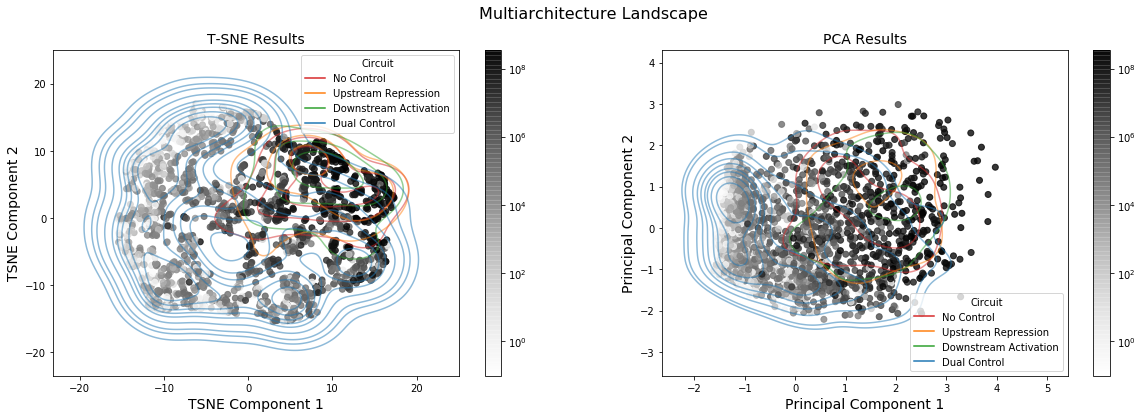

In [40]:
orders = ['No Control', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
palette = {'No Control': sns.color_palette()[3], 'Upstream Repression': sns.color_palette()[1], 'Downstream Activation': sns.color_palette()[2], 'Dual Control': sns.color_palette()[0], 'Initial':'black'}

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
sns.kdeplot(
    data=landscape,
    x="tsne1",
    y="tsne2",
    hue='Circuit',
    thresh=.1, ax=ax, alpha=0.5, hue_order=orders, palette=palette
)
contour = ax.scatter(data=landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Greys', norm=colors.LogNorm())
fig.colorbar(contour, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
contour = ax.scatter(data=landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Greys', norm=colors.LogNorm())
fig.colorbar(contour, ax=ax)
sns.kdeplot(
    data=landscape,
    x="pc1",
    y="pc2",
    hue='Circuit',
    thresh=.1, ax=ax, alpha=0.5, hue_order=orders, palette=palette
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
fig.suptitle('Multiarchitecture Landscape', fontsize=16)
fig.savefig('multiarch_2000_correctcolors')

In [38]:
best_loss = 1000
best_circuit = 'Initial'
best_losses = []
best_losses_circuits = []
for i in range(len(landscape)):
    if landscape.loss[i] < best_loss:
        best_loss = landscape.loss[i]
        best_circuit = landscape.Circuit[i]
    best_losses.append(best_loss)
    best_losses_circuits.append(best_circuit)
landscape['best_losses'] = best_losses
landscape['Best_Loss_Circuit'] = best_losses_circuits

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positiona

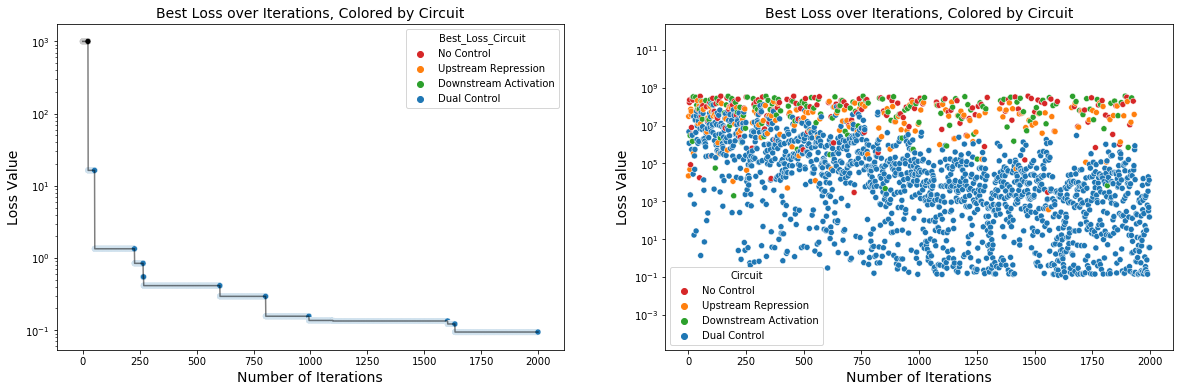

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
endpoint = 'Best Loss over Iterations, Colored by Circuit'

ax = axs[0]
ax.plot(best_losses, 'k-', alpha=0.5)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)
sns.scatterplot(range(len(landscape)), 'best_losses', hue='Best_Loss_Circuit',data=landscape,  ax=ax, hue_order=orders, palette=palette)

ax = axs[1]
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)
sns.scatterplot(range(len(landscape)), 'loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette)
fig.savefig('multiarch_2000_correctcolors_loss')